In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

# 範例

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

valid_f1sc = model.history.history['val_f1sc']

W0730 22:47:15.174579 11388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 22:47:15.230577 11388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 22:47:15.242224 11388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 22:47:15.348689 11388 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

C:\ProgramData\Anaconda3\envs\TensorFlow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 3s 58us/step - loss: 1.7481 - acc: 0.3906 - val_loss: 1.8388 - val_acc: 0.3798
Epoch 3/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.6164 - acc: 0.4344 - val_loss: 1.7069 - val_acc: 0.4052
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5413 - acc: 0.4614 - val_loss: 1.6470 - val_acc: 0.4190
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.4825 - acc: 0.4802 - val_loss: 1.6113 - val_acc: 0.4332
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.4381 - acc: 0.4955 - val_loss: 1.5771 - val_acc: 0.4439
Epoch 7/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.3971 - acc: 0.5144 - val_loss: 1.5518 - val_acc: 0.4502
Epoch 8/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.3624 - acc: 0.5248 - val_loss: 1.5306 - val_acc: 0.4573
Epoch 9/50
50000/50000 [============================

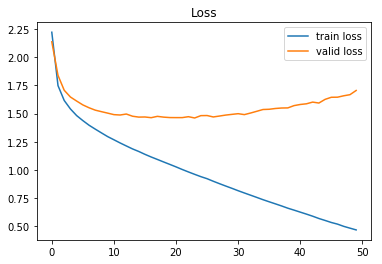

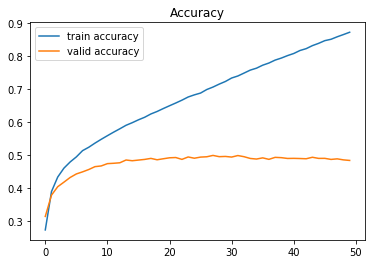

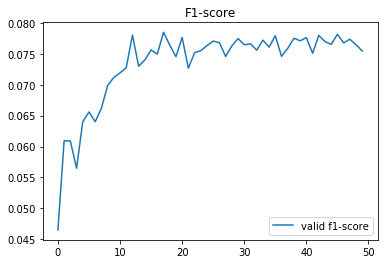

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

# Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [ ]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

array([[3, 0],
       [1, 2]], dtype=int64)

In [14]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    """Define a callback function to collect tp/tn, named Record_fp_tp.
    
    """
    def on_train_begin(self, logs={}):
        logs = logs or {}
        record_items = ['val_auc', 'val_f1sc', 'val_fp', 'val_fn', 'val_tp', 'val_tn']
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs={}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:,1] >= thres) * 1
        
        confusion = confusion_matrix(y_true, y_pred)
        FP = confusion.sum(axis=0) - np.diag(confusion)
        FN = confusion.sum(axis=1) - np.diag(confusion)
        TP = np.diag(confusion)
        TN = confusion.sum() - (FP + FN + TP)
        
        logs['val_tp'] = TP / (TP + FN)
        logs['val_tn'] = TN / (TN + FP)
        
rec_tptn = Record_tp_tn()

In [15]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""
To do:
Fit the model with rec_tptn callback_fn
"""
model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True,
         callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""
To do:
Collect tp/tn from model history
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.4701 - acc: 0.8717 - val_loss: 1.7045 - val_acc: 0.4800


In [18]:
valid_tp

[array([0.99 , 0.166, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.98 , 0.286, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.984, 0.309, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.984, 0.343, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.983, 0.359, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.979, 0.407, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.975, 0.453, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.984, 0.426, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.988, 0.403, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.986, 0.373, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.975, 0.475, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.986, 0.43 , 0.   , 0. 

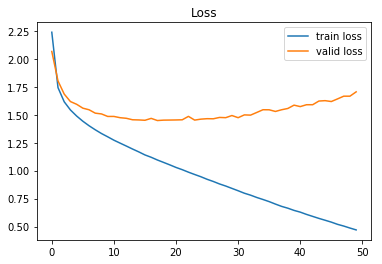

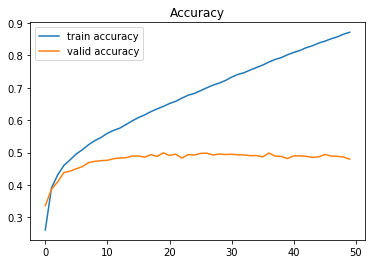

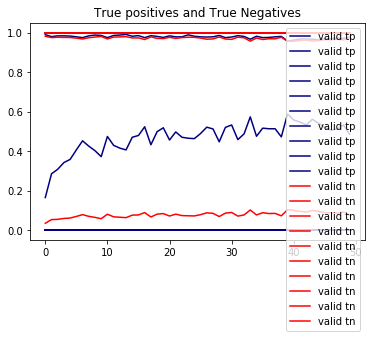

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()